In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

In [59]:
def make_test_df(train_df):
    #print(train_df)
    species_sites = train_df['site_id'].unique()
        
    #print(species_sites)
    
    site_ripenesses = []

    for site in species_sites:
        site_df = train_df[train_df['site_id'] == site]

        site_ripenesses.append({
            'site_id': site,
            'doy': np.mean(site_df['doy'])
        })

    species_test_df = pd.DataFrame(site_ripenesses)
    species_test_df['year'] = high_cutoff_year
    
    return species_test_df

# More specific to our uses.
def train_ripeness_small(observations, predictors, test_observations, test_predictors, model_name = 'ThermalTime'):

    print("running model {m}".format(m=model_name))
    Model = utils.load_model(model_name)
    model = Model()
    model.fit(observations, predictors, optimizer_params='practical')
    
    print(model)
    
    print("making predictions for model {m}".format(m=model_name))        
    preds = model.predict(test_observations, test_predictors)

    #print(preds)
    test_days = test_observations.doy.values
    #print(test_days)
   
    # Various error types
    model_mae = mae(test_days, preds)
    model_rmse = rmse(test_days, preds)
    median_error = np.median(np.abs(test_days - preds))

    print('model {m} got a MAE of {a}'.format(m=model_name,a=model_mae))
    print('model {m} got an RMSE of {a}'.format(m=model_name,a=model_rmse))
    print('model {m}\'s median error is: {a}'.format(m=model_name,a=median_error))

    print("Ripeness Day: {}".format(np.mean(preds)))
    
    ripeness_data = test_observations
    ripeness_data['ripeness_day'] = preds
    
    ripeness_dict = {
        'model_object': model,
        'MAE': model_mae,
        'RMSE': model_rmse,
        'Median Error': median_error,
        'prediction_df': ripeness_data,
    }
    
    return ripeness_dict

Idea for corrections: take the lower error between the base error and the year-transformed error.


Best Approach is:
- High time resolution, correcting for missing data by using averaged data from previous years.
- Add European Weather data.
- No southern hemisphere. 
- Corrected error (i.e. date wrapping). 

Best reporting statistic: what portion of results lie under X.
For example, 80% of results lie under 1 STD, 95% lie under 2 STD. 
Can make a "confidence score" from this – percentile error? Ex. This is less error than 90% of things.  

In [140]:
# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/monthly_weather_data.grib')

core_data = grib_data[0]

print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(rounded_sites['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(rounded_sites['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

## Add Site ID to the weather data
weather_with_sites = pd.merge(formatted_weather, rounded_sites[['coordstring', 'site_id']], on='coordstring')#.drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
print("separating weather data")
weather_with_sites = weather_with_sites[weather_with_sites['year'] != 2023]

weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = weather_with_sites['site_id'].unique()

print("filtering plant data")
filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]

aggressive_filtered_plants = filtered_plants.query('doy <= 145 and doy >= 314')


loading weather data
Loading Plant Data
filtering weather data
formatting weather data
formatting date columns
correcting leap years
adding site IDs to weather data
separating weather data
formatting plant data
filtering plant data


Weather issue: tons of duplicate rows in the "weather with sites" dataframe.

In [141]:
weather_with_sites

,temperature,year,doy,latitude,longitude,coordstring,site_id
0,266.704803,2010,1,43.7,280.6,43.7280.6,1766679
1,266.704803,2010,1,43.7,280.6,43.7280.6,1766576
2,266.704803,2010,1,43.7,280.6,43.7280.6,1760090
3,266.704803,2010,1,43.7,280.6,43.7280.6,1760675
4,266.704803,2010,1,43.7,280.6,43.7280.6,1760092
...,...,...,...,...,...,...,...
1506589,294.614807,2022,214,35.4,280.8,35.4280.8,1826460
1506590,291.424377,2022,245,35.4,280.8,35.4280.8,1826460
1506591,284.783142,2022,275,35.4,280.8,35.4280.8,1826460
1506592,282.997192,2022,306,35.4,280.8,35.4280.8,1826460


In [143]:
euro_data = load_euro_weather_data(euro_path, '../data/high_res_euro_stations.csv')

In [ ]:
## Merge both weather data. 

## If site is in europe data, replace it with the european version. 

# Create a list of "mutual sites".
euro_coords = euro_data['coordstring'].unique()

print("finding mutual sites")
mutual_sites = weather_with_sites[weather_with_sites['coordstring'].isin(euro_coords)][['site_id', 'coordstring']].drop_duplicates()
# Get those sites from europe
mutual_sites_euro = euro_data[euro_data['coordstring'].isin(mutual_sites['coordstring'])]
mutual_sites_euro = mutual_sites_euro.merge(mutual_sites, on='coordstring').drop_duplicates(subset=['coordstring'])

mutual_sites_euro['temperature'] += 272.5

# Remove those sites from monthly 
unmutual_monthly = weather_with_sites[~weather_with_sites['site_id'].isin(mutual_sites['site_id'])]

# rbind the two (a union essentially?)
print("concatenating dataframes")
merged_euro = pd.concat([mutual_sites_euro, unmutual_monthly]).drop('station', axis=1).drop_duplicates()

merged_euro['temperature'] = np.round(merged_euro['temperature'], 1)


finding mutual sites


In [ ]:
merged_euro

In [180]:
mutual_sites

,site_id,coordstring
174960,1722730,44.511.3
174961,1775799,44.511.3
294354,20386,42.33.1
294355,7064,42.33.1
296298,20411,41.31.6
...,...,...
1473553,1591364,46.56.6
1473554,1592510,46.56.6
1480518,1515632,48.316.4
1498662,6947,49.420.4


In [197]:
mutual_sites_euro[['coordstring', 'site_id']].drop_duplicates(subset=['coordstring'])

,coordstring,site_id
0,50.08.4,739
9856,49.37.4,6308
14784,53.123.1,804662
19712,54.418.5,1517465
24640,53.214.4,2494
...,...,...
1727905,49.418.5,6138
1733464,49.419.3,6452
1736961,50.319.0,1774728
1739120,54.59.1,6207


In [199]:
len(mutual_sites_euro['site_id'].unique())

379

In [188]:
coordsite = merged_euro[['coordstring', 'site_id']].drop_duplicates()

In [189]:
coordsite

,coordstring,site_id
0,50.08.4,739
1,50.08.4,2370
9856,49.37.4,6308
14784,53.123.1,804662
19712,54.418.5,1517465
...,...,...
1505790,48.1236.5,1760430
1505952,50.516.9,1769198
1506114,48.5356.1,1718793
1506276,47.2237.6,1759833


Sites are unique, but coordstrings aren't. 

In [195]:
coordsite.drop_duplicates(subset=['coordstring'])

,coordstring,site_id
0,50.08.4,739
9856,49.37.4,6308
14784,53.123.1,804662
19712,54.418.5,1517465
24640,53.214.4,2494
...,...,...
1505790,48.1236.5,1760430
1505952,50.516.9,1769198
1506114,48.5356.1,1718793
1506276,47.2237.6,1759833


In [177]:
def train_species_models(full_plant_data, full_weather_data):
    # Separate weather data into train and test
    weather_training = full_weather_data[full_weather_data['year'] < high_cutoff_year]
    weather_test = full_weather_data[full_weather_data['year'] >= high_cutoff_year]
    
    species_prediction_dict = {}
    species_list = full_plant_data['formatted_sci_name'].unique()

    for s in tqdm(species_list):
        print(s)
        species_train_df = full_plant_data.query('formatted_sci_name == "{}" and year < {}'.format(s, high_cutoff_year))

        if len(species_train_df) == 0:
            continue

        species_test_df = full_plant_data.query('formatted_sci_name == "{}" and year >= {}'.format(s, high_cutoff_year))

       # print(species_train_df, species_test_df)

        if len(species_test_df) == 0:
            # make predictions and compare to the mean ripeness day at each site
            species_test_df = make_test_df(species_train_df)

        if len(species_test_df) == 0:
            print("No test data for {}".format(s))
            #print(species_test_df)
            
        print(species_train_df, weather_training)
        print(species_test_df, weather_test)

        predictions = train_ripeness_small(species_train_df, weather_training,
                            species_test_df, weather_test)

        break
        
        species_prediction_dict[s] = predictions
        
    # gets a list of all the prediction dataframes from the species model
    df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

    full_prediction_df = pd.concat(df_list)

    full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['flowering_day'])
    
    print(score_model(full_prediction_df))
    
    return full_prediction_df


In [179]:
normal_training = train_species_models(filtered_plants, weather_with_sites)
aggressive_training = train_species_models(aggressive_filtered_plants, weather_with_sites)

  0%|                                                                                                                                                                              | 0/95 [00:00<?, ?it/s]

Rubus
        site_id   latitude    doy    year  genus     lon_360  phenophase  \
0       1766679  43.680695  198.0  2020.0  Rubus  280.617281         516   
1       1767585  43.115834  206.0  2020.0  Rubus  279.566474         516   
2       1765950  39.978432  173.0  2020.0  Rubus  276.941349         516   
3       1766160  40.431277  202.0  2020.0  Rubus  280.085982         516   
4       1766160  40.431277  181.0  2020.0  Rubus  280.085982         516   
...         ...        ...    ...     ...    ...         ...         ...   
108166  1516489  53.557442  197.0  2016.0  Rubus  246.516402         516   
108167  1515918  43.079518  179.0  2016.0  Rubus  270.635218         516   
108168   595125  43.476073  280.0  2019.0  Rubus  249.240896         516   
108169  1517688  45.648128  238.0  2016.0  Rubus    2.856274         516   
108170     2838  43.075283  185.0  2014.0  Rubus  270.577240         516   

       formatted_sci_name  rounded_lat  rounded_lon  
0                   Rubus  

  0%|                                                                                                                                                                              | 0/95 [00:02<?, ?it/s]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.6
model ThermalTime got an RMSE of 49.24970389081881
model ThermalTime's median error is: 9.5
Ripeness Day: 187.13333333333333


ValueError: No objects to concatenate

# Model Scoring and Validation

In [61]:
for s in species_prediction_dict.keys():
    print(s, species_prediction_dict[s]['Median Error'])

Rubus 9.5
Rubus occidentalis 6.0
Ficus 18.0
Ficus carica 13.0
Ficus citrifolia 39.5
Ficus macrophylla 7.0
Olea europaea 45.5
Olea europea 17.5
Olea 32.0
Morus rubra 15.5
Morus 15.5
Morus macroura 35.0
Morus alba 7.0
Morus nigra 11.5
Morus australis 19.0
Amelanchier alnifolia 9.0
Amelanchier arborea 28.0
Amelanchier canadensis 14.0
Amelanchier grandiflora 12.5
Amelanchier laevis 13.0
Amelanchier utahensis 30.875
Amelanchier 11.5
Citrus 111.0
Citrus jambhiri 3.0
Citrus limon 63.0
Rubus idaeus 14.5
Rubus hayata 10.0
Rubus phoenicolasius 10.0
Rubus rolfei 11.0
Citrus aurantium 13.5
Citrus sinensis 26.0
Prunus americana 37.0
Prunus domestica 15.0
Prunus maritima 14.5
Prunus nigra 55.0
Prunus cerasifera 13.5
Prunus 29.0
Prunus angustifolia 25.0
Prunus cocomilia 13.0
Prunus salicina 32.0
Prunus subcordata 8.0
Prunus mexicana 8.5
Prunus rivularis 11.0
Eriobotrya japonica 49.0
Malus sieboldii 56.0
Malus 32.0
Malus pumila 24.0
Malus domestica 9.5
Malus sylvestris 14.0
Malus coronaria 41.0
Malus 

TODO for tomorrow: figure out why it's still defaulting to monthly instead of taking some euro data. 

In [74]:
# gets a list of all the prediction dataframes from the species model
df_list = [i['prediction_df'] for i in species_prediction_dict.values()]

full_prediction_df = pd.concat(df_list)

full_prediction_df['abs_error'] = np.abs(full_prediction_df['doy'] - full_prediction_df['flowering_day'])

In [114]:
## STATS

# get confidence intervals for species

def calc_confidence_interval():
    pass

def score_model(prediction_df):
    observed = prediction_df['doy']
    predicted = prediction_df['flowering_day']
    
    median_err = np.median(prediction_df['abs_error'])
    std = np.std(prediction_df['abs_error'])
    
    # MAE, RMSE, median
    print("Error metrics:")
    print("MAE:", mae(observed, predicted))
    print("RMSE:", rmse(observed, predicted))
    print("Median Absolute Error:", median_err)
    
    # portion of errors under the median
    print("Median portion (median error = {})".format(median_err))
    print(len(prediction_df.query('abs_error < {}'.format(median_err))) / len(prediction_df))
    
    # portion of errors under the SD
    print("SD portion (SD = {})".format(std))
    print(len(prediction_df.query('abs_error < {}'.format(std))) / len(prediction_df))
    
    print("Month threshold:")
    print(len(prediction_df.query('abs_error < 30')) / len(prediction_df))

    # 
    print("2 * SD portion (2SD = {})".format(2 * std))
    print(len(prediction_df.query('abs_error < {}'.format(2 * std))) / len(prediction_df))
    

# get how "good" one sample is compared to the whole sample
def calc_error_percentile(sample, full_sample):
    sample_median = np.median(sample['abs_error'])
    
    print(sample_median)
    print(1 - len(full_sample.query('abs_error < {}'.format(sample_median))) / len(full_sample))

In [99]:
for g in full_prediction_df['genus'].dropna().unique():
    g_df = full_prediction_df[full_prediction_df['genus'] == g]
    print(g)
    calc_error_percentile(g_df, full_prediction_df)

Rubus
10.0
0.6075816075816076
Ficus
16.0
0.44120744120744115
Olea
41.0
0.14215514215514213
Morus
13.0
0.5135135135135135
Amelanchier
13.0
0.5135135135135135
Citrus
110.0
0.02211302211302213
Prunus
19.0
0.3783783783783784
Eriobotrya
49.0
0.10810810810810811
Malus
30.0
0.23727623727623726
Rosmarinus
90.0
0.03404703404703402
Juglans
16.0
0.44120744120744115
Cornus
32.0
0.2169182169182169
Diospyros
17.5
0.40400140400140405
Pyrus
28.0
0.2628992628992629


In [115]:
score_model(full_prediction_df)

Error metrics:
MAE: 21.891178292476994
RMSE: 34.257129283602936
Median Absolute Error: 13.0
Median portion (median error = 13.0)
0.4864864864864865
SD portion (SD = 26.35008955811099)
0.7237627237627238
Month threshold:
0.7627237627237627
2 * SD portion (2SD = 52.70017911622198)
0.9143559143559143


In [85]:
np.std(full_prediction_df['abs_error'])

26.35008955811099

(array([470., 425., 304., 309., 200., 180., 106., 135., 102., 114.,  74.,
         57.,  38.,  56.,  45.,  22.,  24.,  15.,  17.,  10.,  17.,  11.,
          8.,   9.,   2.,  14.,   5.,   6.,   6.,   3.,   5.,  11.,   1.,
          0.,   6.,   0.,   1.,   1.,   6.,   8.,   0.,   1.,   6.,   2.,
          2.,   4.,   2.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   2.]),
 array([  0.  ,   3.55,   7.1 ,  10.65,  14.2 ,  17.75,  21.3 ,  24.85,
         28.4 ,  31.95,  35.5 ,  39.05,  42.6 ,  46.15,  49.7 ,  53.25,
         56.8 ,  60.35,  63.9 ,  67.45,  71.  ,  74.55,  78.1 ,  81.65,
         85.2 ,  88.75,  92.3 ,  95.85,  99.4 , 102.95, 106.5 , 110.05,
        113.6 , 117.15, 120.7 , 124.25, 127.8 , 131.35, 134.9 , 138.45,
        142.  , 145.55, 149.1 , 152.65, 156.2 , 159.75, 163.3 , 166.85,
        170.4 , 173.95, 177.5 , 181.05, 184.6 , 188.15, 191.7 , 195.25,
        198.8 , 202.35, 205.9 , 209.45, 213.  ]),
 <BarContainer object of 60 artists>

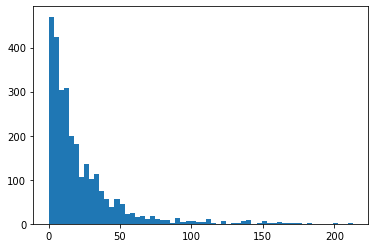

In [86]:
plt.hist(full_prediction_df['abs_error'], bins=60)

In [102]:
full_prediction_df[full_prediction_df['abs_error'] >= 100].sort_values('abs_error', ascending=False)[0:50]

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
36,8,39.910755,62.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,213.0
50,2,38.376015,63.0,2022.0,Malus,237.491870,516.0,Malus sieboldii,38.4,237.5,275,212.0
46,8,39.910755,75.0,2022.0,Diospyros,273.575810,516.0,Diospyros virginiana,39.9,273.6,275,200.0
542,34,43.008286,63.0,2022.0,Malus,281.216940,516.0,Malus,43.0,281.2,245,182.0
182,1824168,32.078188,357.0,2022.0,Citrus,34.802053,516.0,Citrus,32.1,34.8,183,174.0
193,1824165,32.026304,356.0,2022.0,Citrus,278.925524,516.0,Citrus,32.0,278.9,183,173.0
492,4,34.051340,73.0,2022.0,Olea,241.796875,516.0,Olea europaea,34.1,241.8,245,172.0
98,1823026,33.922294,289.0,2022.0,Eriobotrya,241.593083,516.0,Eriobotrya japonica,33.9,241.6,122,167.0
324869,3096,39.997452,108.0,2022.0,Malus,254.717300,516.0,Malus pumila,40.0,254.7,275,167.0
413,1824101,32.056094,349.0,2022.0,Citrus,34.799296,516.0,Citrus,32.1,34.8,183,166.0


In [103]:
full_prediction_df

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,flowering_day,abs_error
19,1812903,42.000443,183.0,2022.0,Rubus,268.349632,516.0,Rubus,42.0,268.3,183,0.0
20,1812992,43.123822,181.0,2022.0,Rubus,282.422069,516.0,Rubus,43.1,282.4,183,2.0
22,1813012,35.219765,190.0,2022.0,Rubus,270.150501,516.0,Rubus,35.2,270.2,183,7.0
23,1813095,43.026309,193.0,2022.0,Rubus,274.317216,516.0,Rubus,43.0,274.3,183,10.0
25,1810562,37.417095,165.0,2022.0,Rubus,280.809241,516.0,Rubus,37.4,280.8,183,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1,1759647,NaN,240.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,35.0
2,1760749,NaN,271.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,4.0
0,1769198,NaN,261.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,14.0
1,1718728,NaN,281.0,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,275,6.0


In [104]:
74 / 2849

0.025974025974025976

(array([  34.,   33.,   22.,   44.,   39.,   14.,   33.,   31.,   28.,
          34.,   34.,   23.,   44.,   55.,   33.,   38.,   56.,   31.,
          31.,   48.,   46.,   35.,   21.,   47.,   38.,   46.,   55.,
          56.,   36.,   42.,   42.,   26.,   51.,   55.,   37.,   40.,
          56.,   59.,  106.,   87.,  206.,  295.,  286.,  474.,  612.,
         590.,  892.,  860.,  653.,  814.,  678.,  470.,  698.,  657.,
         616.,  709.,  868.,  590.,  962.,  581.,  771.,  767.,  502.,
         816.,  753.,  518.,  721.,  677.,  512.,  833.,  885.,  763.,
         846., 1062.,  928., 1064.,  974.,  920.,  855.,  529.,  606.,
         387.,  218.,  196.,  149.,   74.,   82.,   68.,   63.,   41.,
          45.,   49.,   48.,   49.,   24.,   50.,   28.,   26.,   24.,
          17.]),
 array([  1.  ,   4.65,   8.3 ,  11.95,  15.6 ,  19.25,  22.9 ,  26.55,
         30.2 ,  33.85,  37.5 ,  41.15,  44.8 ,  48.45,  52.1 ,  55.75,
         59.4 ,  63.05,  66.7 ,  70.35,  74.  ,  77.65,  8

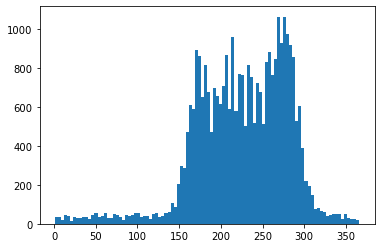

In [106]:
plt.hist(formatted_plants['doy'], bins=100)

Based on this histogram, most of the observations fall between like 150 and 315 days. Very odd. Same is true for the filtered plants. Is it just noise? 

Could probably cut off days with <20 observations (145 - 314). 

(array([ 30.,  17.,  11.,  32.,  34.,  12.,  13.,  10.,  30.,  23.,  26.,
         26.,  19.,  30.,  21.,  20.,  33.,  18.,  23.,  26.,  30.,  33.,
         22.,  27.,  39.,  56.,  66.,  89., 110., 162., 228., 283., 315.,
        527., 588., 642., 646., 626., 642., 597., 527., 499., 525., 454.,
        467., 530., 598., 540., 634., 581., 935., 573., 600., 495., 556.,
        478., 622., 528., 537., 469., 552., 460., 457., 636., 594., 614.,
        901., 704., 730., 896., 774., 686., 901., 648., 648., 494., 474.,
        298., 222., 169., 108., 106.,  70.,  68.,  46.,  57.,  43.,  24.,
         26.,  39.,  36.,  30.,  27.,  20.,  32.,  17.,  21.,  12.,  22.,
         12.]),
 array([ 60.  ,  63.06,  66.12,  69.18,  72.24,  75.3 ,  78.36,  81.42,
         84.48,  87.54,  90.6 ,  93.66,  96.72,  99.78, 102.84, 105.9 ,
        108.96, 112.02, 115.08, 118.14, 121.2 , 124.26, 127.32, 130.38,
        133.44, 136.5 , 139.56, 142.62, 145.68, 148.74, 151.8 , 154.86,
        157.92, 160.98, 164.04

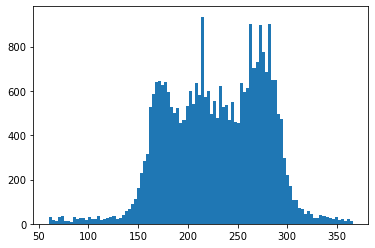

In [107]:
plt.hist(filtered_plants['doy'], bins=100)

In [110]:
dict(filtered_plants.groupby('doy').size())

{60.0: 8,
 61.0: 5,
 62.0: 6,
 63.0: 11,
 64.0: 4,
 65.0: 6,
 66.0: 7,
 67.0: 5,
 68.0: 3,
 69.0: 3,
 70.0: 8,
 71.0: 8,
 72.0: 16,
 73.0: 14,
 74.0: 4,
 75.0: 16,
 76.0: 4,
 77.0: 4,
 78.0: 4,
 79.0: 4,
 80.0: 5,
 81.0: 4,
 82.0: 3,
 83.0: 4,
 84.0: 3,
 85.0: 8,
 86.0: 6,
 87.0: 16,
 88.0: 9,
 89.0: 5,
 90.0: 9,
 91.0: 9,
 92.0: 4,
 93.0: 13,
 94.0: 8,
 95.0: 8,
 96.0: 10,
 97.0: 8,
 98.0: 5,
 99.0: 6,
 100.0: 10,
 101.0: 13,
 102.0: 7,
 103.0: 10,
 104.0: 4,
 105.0: 7,
 106.0: 8,
 107.0: 6,
 108.0: 6,
 109.0: 8,
 110.0: 12,
 111.0: 9,
 112.0: 4,
 113.0: 4,
 114.0: 9,
 115.0: 5,
 116.0: 12,
 117.0: 3,
 118.0: 8,
 119.0: 9,
 120.0: 6,
 121.0: 11,
 122.0: 10,
 123.0: 9,
 124.0: 11,
 125.0: 11,
 126.0: 11,
 127.0: 11,
 128.0: 5,
 129.0: 4,
 130.0: 13,
 131.0: 8,
 132.0: 7,
 133.0: 12,
 134.0: 12,
 135.0: 12,
 136.0: 15,
 137.0: 14,
 138.0: 25,
 139.0: 17,
 140.0: 27,
 141.0: 18,
 142.0: 21,
 143.0: 36,
 144.0: 18,
 145.0: 35,
 146.0: 32,
 147.0: 27,
 148.0: 51,
 149.0: 31,
 150.0: 74,
 1

In [111]:
aggressive_filtered_plants = filtered_plants.query('doy <= 145 and doy >= 314')

In [ ]:
genus_prediction_dict = {}

for s in tqdm(filtered_plants['genus'].unique()):
    print(s)
    species_train_df = filtered_plants.query('genus == "{}" and year < {}'.format(s, high_cutoff_year))
    
    if len(species_train_df) == 0:
        continue
    
    species_test_df = filtered_plants.query('genus == "{}" and year >= {}'.format(s, high_cutoff_year))
    
    if len(species_test_df) == 0:
        # make predictions and compare to the mean ripeness day at each site
        species_test_df = make_test_df(species_train_df)
    
    if len(species_test_df) == 0:
        print("No test data for {}".format(s))
        #print(species_test_df)
        
    predictions = train_ripeness_small(species_train_df, weather_training,
                        species_test_df, weather_test)
    
    genus_prediction_dict[s] = predictions